In [1]:
import os
import sys
import pathlib
import warnings
import numpy as np
import pandas as pd
from pprint import pprint
import tensorflow as tf
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.augmented_simulators.tensorflow_models.powergrid import TfResNetPowerGrid
from lips.dataset.scaler import StandardScaler
from lips.utils import get_path

In [2]:
# set some environment variables
sys.path.insert(0, "../../")

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
  except RuntimeError as e:
    print(e)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
pd.set_option('display.max_columns', None)

In [4]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

# 1. l2rpn_case14_sandbox grid

## 1.1 Benchmark1: Risk assessment through contingency screening

In [5]:
benchmark1 = PowerGridBenchmark(benchmark_name="Benchmark1",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH
                               )

In [ ]:
topo_actions = benchmark1.config.get_option("dataset_create_params")["reference_args"]["topo_actions"]

kwargs_tau = []
for el in topo_actions:
     kwargs_tau.append(el["set_bus"]["substations_id"][0])
                       
pprint(kwargs_tau)

### Tensorflow ResNet 

In [8]:
tf_resnet = TfResNetPowerGrid(name="tf_resnet",
                             bench_config_path=BENCH_CONFIG_PATH,
                             bench_config_name="Benchmark1",
                             topo_vect_to_tau="given_list",
                             kwargs_tau=kwargs_tau,
                             layers = [200, 200, 200],
                             lr = 1e-4,
                             loss = {"name": "mse"},
                             layer = "resnet",
                             activation = "relu",
                             sim_config_path=SIM_CONFIG_PATH / "tf_fc.ini",
                             sim_config_name="DEFAULT",
                             log_path=LOG_PATH,
                             scale_input_layer = True,
                             scaler = StandardScaler,
                            )

## Training

In [ ]:
tf_resnet.train(train_dataset=benchmark1.train_dataset,
                val_dataset=benchmark1.val_dataset,
                batch_size=128,
                epochs=400)

## Visualization

In [ ]:
tf.keras.utils.plot_model(
    tf_resnet._model,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations= True)

In [ ]:
tf_resnet.summary()

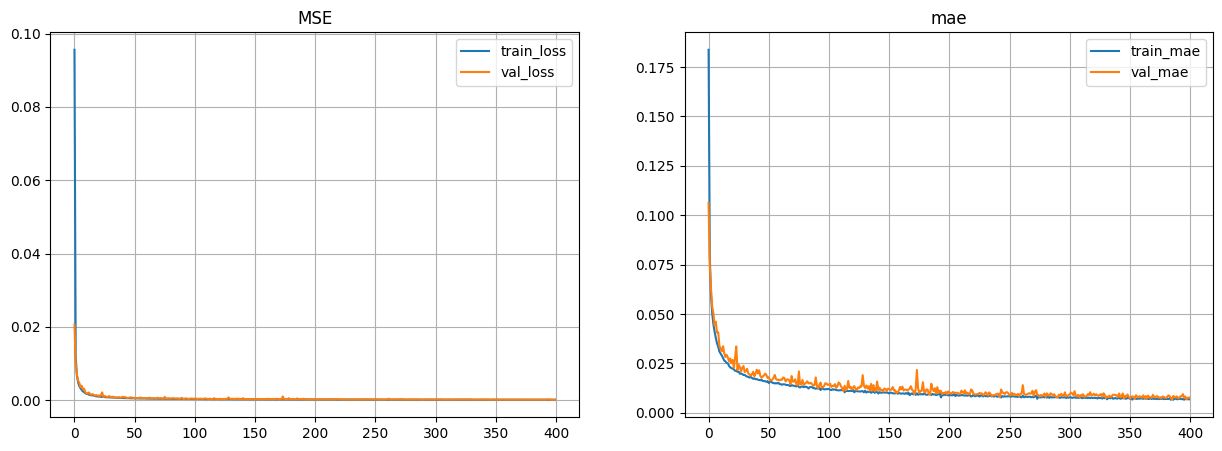

In [12]:
tf_resnet.visualize_convergence()

## Evaluation

In [ ]:
eval_metrics = benchmark1.evaluate_simulator(augmented_simulator=tf_resnet,
                                             eval_batch_size=128,
                                             dataset="all",
                                             shuffle=False,
                                             save_predictions=True
                                            )

In [13]:
SAVE_PATH = get_path(TRAINED_BASELINES_PATH, benchmark1)
tf_resnet.save(SAVE_PATH)

In [15]:
print("ML : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test"]["ML"]["mape_90_avg"].values()))))
print("ML : Inf speed-up :", eval_metrics["test"]["ML"]["TIME_INF"])
print("Rediness : Inf speed-up :", tf_fc_metrics1["test"]["IndRed"]["TIME_INF"])
print("OOD : MAPE90 --> A : mean :{}, std :{}".format(np.mean(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values())), np.std(list(eval_metrics["test_ood_topo"]["ML"]["mape_90_avg"].values()))))

ML : MAPE90 --> A : mean :0.0018794984789735378, std :6.2730239130942686e-06
ML : Inf speed-up : 0.125948318047449
Rediness : Inf speed-up : 0.13259111298248172
OOD : MAPE90 --> A : mean :0.1516528092253535, std :5.690003941975774e-05


In [16]:
testset_violoation = [tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : test --> CURRENT_POS : mean :{}, std :{}".format(np.mean(testset_violoation), np.std(testset_violoation)))

Physics : test --> CURRENT_POS : mean :0.029997, std :0.0007190000000000009


In [17]:
oodset_violoation = [tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_or"]["Violation_proportion"], tf_fc_metrics1["test_ood_topo"]["Physics"]["CURRENT_POS"]["a_ex"]["Violation_proportion"]]
print("Physics : ood --> CURRENT_POS : mean :{}, std :{}".format(np.mean(oodset_violoation), np.std(oodset_violoation)))

Physics : ood --> CURRENT_POS : mean :0.0121895, std :0.00019950000000000002
